# Unsupervised learning of Maxwell's equations

In [8]:
import torch 
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, random_split
from pdb import set_trace as breakpoint
from time import time
# from tensorboardX import SummaryWriter

import numpy as np
import matplotlib.pyplot as plt
import h5py

# from datasets.generators import *
from datasets.generators1d import * 
from models.utils import pbar

## Unsupervised 1D convolutional model

In [23]:
make_batch(perm_alternating_layers, "datasets/test_1d_unsupervised.hdf5", "alternating_layers_test", N=10**3)

IndexError: index 0 is out of bounds for axis 0 with size 0

In [3]:
data_batch = load_batch("datasets/test_1d_unsupervised.hdf5", "alternating_layers")

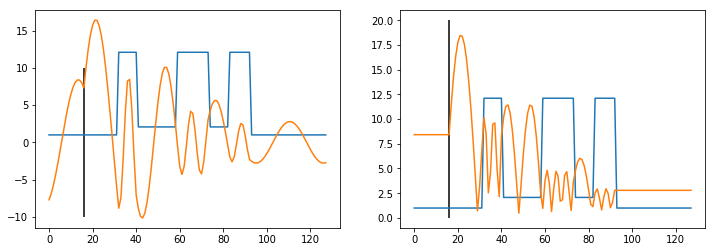

In [4]:
n = np.random.randint(0,500)
f, axarr = plt.subplots(1, 2, figsize=(12,4))

epsilons = data_batch["epsilons"][n]
src_x = data_batch["src"][n]
Hx = data_batch["Hx"][n]
Hy = data_batch["Hy"][n]
Ez = data_batch["Ez"][n]
        
axarr[0].plot(epsilons)
axarr[0].plot(np.imag(Ez))
axarr[0].vlines(src_x, -10, 10)

axarr[1].plot(epsilons)
axarr[1].plot(np.abs(Ez))
axarr[1].vlines(src_x, 0, 20)

plt.show()

In [5]:
diffs = np.diff(np.imag(Ez), n=2)
ez = np.imag(Ez)[1:-1]
# ez = np.real(Ez)[0:-2]
eps = epsilons[1:-1]
# eps = epsilons[2:]

In [2]:
OMEGA = 1.215e15
MU0 = 4 * np.pi * 10**-7
EPSILON0 =  8.854187817620e-12 
SCALE = 1e-15
C = 299792458.0
L0 = 1e-6
PIXEL_SIZE = 0.05 * L0
wavelength = 2 * np.pi * C / OMEGA

x = PIXEL_SIZE * (np.arange(eps.shape[0]) - src_x)
# Check wave equation terms match
left = SCALE * diffs / PIXEL_SIZE**2
right = SCALE * -OMEGA**2 * MU0 * EPSILON0 * eps * ez
plt.plot(left, label="left")
plt.plot(right, label="right")
# Cosine fit
# plt.plot(2 * np.cos(np.sqrt(eps) * OMEGA/C * x))
# Residual
plt.plot((left - right))
plt.legend()
plt.show()

print((left - right)[15])

NameError: name 'eps' is not defined

### 1D convolutional model definitions

In [3]:
class Perm1dDataset_test(Dataset):
    
    def __init__(self, hdf5_file, batch_name, kernel_sizes = []):
        
        data = load_batch(hdf5_file, batch_name)
        
        self.epsilons = data["epsilons"] 
        self.src = data["src"]
        self.Ez = data["Ez"]
                
        self.input_size = self.Ez[0].shape[0]
        output_size = self.input_size
        for kernel_size in kernel_sizes:
            stride = 1
            output_size = (output_size - kernel_size) / stride + 1
        self.output_size = int(output_size)
        
    def __len__(self):
        return len(self.epsilons)

    def __getitem__(self, i):
        epsilons = torch.tensor(self.epsilons[i])
        src_x = self.src[i]
        fields = torch.tensor(np.imag(self.Ez[i])) # TODO: change to real
        return epsilons.float(), src_x, fields.float()

class Perm1dDataset(Dataset):
    
    def __init__(self, epsilon_generator, kernel_sizes = [], N=10000, input_size=128, infinite_mode=False):
        self.input_size = input_size
        output_size = self.input_size
        for kernel_size in kernel_sizes:
            stride = 1
            output_size = (output_size - kernel_size) / stride + 1
        self.output_size = int(output_size)
        
        self.epsilon_generator = epsilon_generator
        self.epsilon_samples = []
        self.src_samples = []
        self.N = N
        self.infinite_mode = infinite_mode
        
    def __len__(self):
        if self.infinite_mode:
            return int(1e8)
        else:
            return int(self.N)

    def __getitem__(self, i):
        if i >= len(self.epsilon_samples) or self.infinite_mode:
#             src = torch.zeros(self.input_size)
#             src_x = np.random.randint(1,32)
#             src[src_x] = 1.0
            epsilons = np.ones(self.input_size)
            epsilons[32:96] = self.epsilon_generator()
            epsilons = torch.tensor(epsilons).float()
            src_x = np.random.randint(1,127-1) # 16 # TODO
            if not self.infinite_mode:
                self.epsilon_samples.append(epsilons)
                self.src_samples.append(src_x)
            return epsilons, src_x, torch.zeros(epsilons.shape).float()
        else:
            epsilons = self.epsilon_samples[i]
            src_x = self.src_samples[i]
            return epsilons.float(), src_x, torch.zeros(epsilons.shape).float()

In [4]:
def tensor_diff(a, n=1, axis=-1):
    '''PyTorch equivalent of numpy.diff()'''
    if n == 0:
        return a
    if n < 0:
        raise ValueError("order must be non-negative but got " + repr(n))
    length = a.shape[axis] - 1
    a0 = a.narrow(axis, 0, length)
    a1 = a.narrow(axis, 1, length)
    return tensor_diff(a1 - a0, n=n-1, axis=axis)

In [5]:
class MaxwellDense(nn.Module):
    def __init__(self, size=128):
        super().__init__()
        
        self.size = size

#         self.layer_dims = [self.size, 256, 512, 512, 256, self.size]
        self.layer_dims = [2 * self.size, 512, 256, self.size]

        layers_amp = []
        layers_phi = []
        for i in range(len(self.layer_dims) - 1):
            layers_amp.append(nn.Linear(self.layer_dims[i], self.layer_dims[i+1]))
            layers_phi.append(nn.Linear(self.layer_dims[i], self.layer_dims[i+1]))
            
        self.layers_amp = nn.ModuleList(layers_amp)
        self.layers_phi = nn.ModuleList(layers_phi)
        
    def forward_amplitude_phase(self, x):
        A = x
        for i, layer in enumerate(self.layers_amp):
            A = layer(A)
            if i < len(self.layers_amp) - 1:
                A = nn.ReLU()(A)
                
        phi = x
        for i, layer in enumerate(self.layers_phi):
            phi = layer(phi)
            if i < len(self.layers_amp) - 1:
                phi = nn.ReLU()(phi)
        
        return A, phi
    
    def get_fields(self, epsilons, src):
        # Get amplitude and phase vectors
        data = torch.cat((epsilons, src), dim=-1)
        A, phi = self.forward_amplitude_phase(data)#epsilons)
            
        # Combine to form waveform
        x = (PIXEL_SIZE * (torch.arange(self.size) # - src_x
                          )).float()
        fields = A * torch.cos(OMEGA / C * torch.sqrt(epsilons) * x + phi)
        return fields
        
    def forward(self, epsilons, src):
        
        
        
        fields = self.get_fields(epsilons, src)

        eps = epsilons[:,1:-1]
        E = fields[:,1:-1]
        
        # Compute Maxwell operator on fields
        curl_curl_E = tensor_diff(fields, n=2)
        left_factor =  SCALE / PIXEL_SIZE**2
        right_factor = SCALE * -OMEGA**2 * MU0 * EPSILON0
        
        out = (left_factor * curl_curl_E) - (right_factor * eps * E) - src[:,1:-1]
        
        return out

In [6]:
def perm_generator_vacuum():
    return np.ones(64)

In [10]:
# Device configuration
device = torch.device('cpu')

# Create a model   
model = MaxwellDense().to(device)
# writer = SummaryWriter()

# Create data loaders
batch_size = 500

# train_data = Perm1dDataset(perm_generator_vacuum, N=10000, infinite_mode=False)
train_data = Perm1dDataset(perm_alternating_layers, N=1e6, infinite_mode=False)
train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)

# test_data = Perm1dDataset_test("datasets/test_1d_unsupervised.hdf5", "alternating_layers")
# test_loader = DataLoader(dataset=test_data, batch_size=1, shuffle=False)

In [12]:
# # Hyperparameters
# num_epochs = 250
# learning_rate = 0.00001

# # Loss and optimizer
# criterion = nn.MSELoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)#, weight_decay=0.1)
# # losses = []

# # Train the model
# model.train()
# total_step = len(train_loader)
# epoch_iterator = pbar(range(num_epochs))
# params = []

# for epoch in epoch_iterator:
    
#     iterator = pbar(train_loader)
#     for epsilons, src_x, _ in iterator:
        
# #         params.append([tensor.clone() for tensor in model.parameters()])

        
#         src = torch.zeros(*epsilons.shape)
#         src[:,src_x] = 1.526814027933079
        
#         epsilons = epsilons.to(device)
#         src = src.to(device)
        
#         # Forward pass
#         outputs = model(epsilons, src)
#         loss = criterion(outputs, torch.zeros(outputs.shape))
# #         losses.append(loss.item())
        
#         # Backward and optimize
#         optimizer.zero_grad()
#         loss.backward()
        
# #         breakpoint() 
        
#         optimizer.step()
        
#         iterator.set_description("ℒ = {:.4f}".format(loss.item()), refresh=False)

# # Save the model checkpoint
# torch.save(model.state_dict(), 'model1d.ckpt')

In [13]:
model.load_state_dict(torch.load("model1d_nov27.ckpt"))

In [14]:
# model.eval()  # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)
# data_list = []
# src_x_list = []
# labels_list = []
# outputs_list = []

# with torch.no_grad():
#     for data, src_x, labels in pbar(test_loader):
#         data = data.to(device)
#         labels = labels.to(device)
#         outputs = model(data, src_x)
#         data_list.append(data)
#         src_x_list.append(src_x)
#         labels_list.append(labels)
#         outputs_list.append(outputs)
        
# t_true = [tensor.item() for tensor in labels_list]
# t_pred = [tensor.item() for tensor in outputs_list]

In [14]:
model.eval()

# perms = perm_generator_vacuum()
perms = perm_alternating_layers()
start = time()
_, _, _, _, Ez = Simulation1D(npml=0).solve(perms, omega=OMEGA_1550)
sim_time = time() - start

epsilons_test = np.ones(128)
epsilons_test[32:96] = perms
epsilons_test = torch.tensor([epsilons_test]).float()

src_x_test = np.random.randint(1,126)
src_test = torch.zeros(*epsilons_test.shape)
src_test[:,src_x_test] = 1.526814027933079

start = time()
outputs = model.get_fields(epsilons_test, src_test)
network_time = time() - start

print(sim_time, network_time, network_time / sim_time)

0.014110803604125977 0.45137643814086914 31.988003717158065


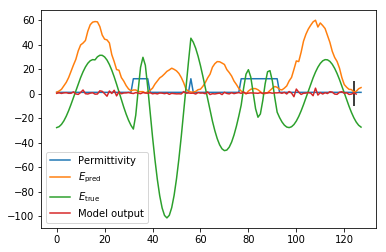

In [15]:
plt.plot(epsilons_test[0].detach().numpy(), label="Permittivity")
plt.plot(outputs[0].detach().numpy(), label="$E_\mathrm{pred}$")
plt.plot(np.imag(Ez), label="$E_\mathrm{true}$")
plt.plot(model(epsilons_test, src_test)[0].detach().numpy(), label="Model output")
plt.vlines(src_x_test, -10, 10)
plt.legend()
plt.show()

## Cavity experiments

In [22]:
perms = np.ones(65)# perm_alternating_layers(s=65)
eps, src_x, _, _, Ez = Cavity1D(npml=0).solve(perms, omega=OMEGA_1550)

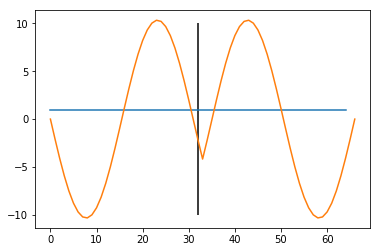

In [26]:
plt.plot(eps[16:-16])
plt.plot(np.imag(Ez[15:-15]), label="$E_\mathrm{true}$")
plt.vlines(src_x, -10, 10)
plt.show()

/Users/ben/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


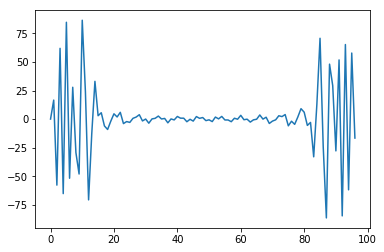

In [14]:
plt.plot(np.fft.fft(Ez))
plt.show()

In [21]:
Ez[-17]

-0.05182742512019615j

In [33]:
(0,)*6*2

(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)

In [30]:
a = torch.reshape(torch.arange(10), (2,5))

In [32]:
len(a.shape)

2